In [2]:
library(brms)
library(dplyr)
library(data.table)

library(tidyverse)
library(ggridges)
library(gridExtra)
library(svglite)
options(warn = -1)

In [3]:
data.loader <- function(path){
    load(path)
    
    EOIq <- unlist(lapply(strsplit(mod,'\\+')[[1]],trimws))
    if(!('Intercept' %in% EOIq)) EOIq <- c('Intercept', EOIq)
    EOIq <- EOIq[!grepl('1', EOIq)]
    
    aa <- fixef(fm, summary = FALSE)/SCALE # Population-Level Estimates
    bb <- lapply(ranef(fm, summary = FALSE), `/`, SCALE) # Extract Group-Level (or random-effect)
    
    res <-list(EOIq, aa, bb)
    return(res)
}

psROI <- function(aa, bb, tm) {
    ps <- apply(bb[['ROI']][,, tm], 2, '+', aa[, tm])
    return(ps)
}

In [4]:
early <- data.loader("results_offset/model1/early_diff.RData")
late <- data.loader("results_offset/model1/late_diff.RData")
period <- data.loader("results_offset/model2/period_diff.RData")

In [5]:
rank.early <- read.table('results_offset/model2/Rank_Intercept_early.csv', header=TRUE, sep=',')

rank.early <- rank.early %>% mutate(Rank = as.integer(86 - rank)) %>% 
                        select(ROI, Rank, p_plus) %>% rename(rank = Rank, pplus = p_plus) %>% arrange(rank)

In [6]:
ps.early <- psROI(early[[2]], early[[3]], "Intercept")
ps.late <- psROI(late[[2]], late[[3]], "Intercept")
ps.period <- psROI(period[[2]], period[[3]], "phase")

In [7]:
plotPDP <- function(posteriors.early, posteriors.late){
    
    # prepare the dataframe
    posteriors.early <- posteriors.early %>% as_tibble()
    posteriors.late <- posteriors.late %>% as_tibble()
    
    replace_name <- function(posteriors){
        name <- read.table("data/name.txt", header = TRUE, sep = ",")
        name[] <- lapply(name, as.character)
        name[] <- lapply(name, str_trim, side = "both")
        colnames(posteriors) <- stringr::str_replace_all(posteriors %>% colnames(), setNames(pull(name["new"]), pull(name["old"])))
        
        return(posteriors)
    }

    p_plus <- function(x){
        return(sum(x > 0, na.rm = TRUE)/length(x))
    }
    
    create_ps_long <- function(posteriors){
        P_df <- apply(posteriors, 2, p_plus) %>% as.data.frame()
        P_df <- tibble(ROI = row.names(P_df), 
                       p_plus = P_df[, 1],
                       mean = apply(posteriors, 2, mean))
        P_df <- P_df %>% left_join(rank.early, by = 'ROI') %>% arrange(rank)
        
        ps_long <- gather(posteriors, key = "ROI", value = "posterior")
        
        ps_long <- full_join(ps_long, P_df, by = "ROI") %>% 
                    mutate(p.plot = p_plus) %>% 
                    mutate(p.plot = replace(p.plot, p.plot > 0.15 & p.plot < 0.85, NA))
        
        res <- list(P_df, ps_long)
        
        return(res)
    }
    
    ps_long.early <- create_ps_long(replace_name(posteriors.early))[[2]]
    ps_long.late <- create_ps_long(replace_name(posteriors.late))[[2]]
    
    P_axis <- create_ps_long(replace_name(posteriors.early))[[1]] %>% 
                    full_join(create_ps_long(replace_name(posteriors.late))[[1]], by = 'ROI', suffix = c("_early", "_late")) %>%
                    mutate(P = paste0(as.character(format(round(p_plus_early, 3), nsmall = 2)), 
                           " -> ", as.character(format(round(p_plus_late, 3), nsmall = 2))))
    
    xmin <- min(ps_long.late$posterior)
    xmax <- max(ps_long.late$posterior)
    
    ## starting plotting
    plot <- ps_long.early %>%
        ggplot(aes(x = posterior, y = as.numeric(rank), group = ROI)) +
        coord_cartesian(xlim = c(xmin, xmax), 
                        clip = "off") +
        geom_density_ridges(rel_min_height = .001,
                            scale = 1.1,
                            alpha = 0.8, 
                            color = '#000000',
                            quantile_lines = TRUE,
                            quantiles = 2, 
                            size = 0.5, 
                            fill = '#907460') +
        geom_density_ridges(data = ps_long.late, 
                            scale = 1.1,
                            rel_min_height = .001, 
                            alpha = 0.8, 
                            color = '#000000',
                            quantile_lines = TRUE,
                            quantiles = 2, 
                            size = 0.5, 
                            fill = '#f5f1df') +
        geom_vline(xintercept = 0, alpha = .85, color = "black", size = .8, linetype = "dashed") +
        scale_x_continuous(breaks = c(-1.5, -1, -0.5, 0, 0.5, 1), 
                           labels = c("-1.5", "-1\nSafe > Threat", "-0.5", "0", "0.5\nSafe < Threat", "1")) +
        scale_y_continuous(breaks = 1:length(rank.early$ROI),
                           expand = c(0,0.1),
                           labels = P_axis$ROI,
                           sec.axis = sec_axis(~.,
                                               breaks = 1:length(P_axis$ROI),
                                               labels = P_axis$P)) +
        theme_ridges(center_axis_labels = TRUE, grid = FALSE) +
        theme(
            plot.background = element_blank(),
            panel.background = element_blank(),
            panel.grid.major.y = element_line(color = "lightgray", size = .75),
            plot.title = element_text(size = 17, margin = unit(c(0,0.1,.25,02),"cm"), face = "plain", hjust = 0.5),
            plot.margin = unit(c(1, 2.5, 1, 1), "cm"),
            text = element_text(family = "Helvetica Light"),
            axis.title = element_text(size = 16),
            axis.line = element_line(size = .25),
            axis.text.y = element_text(size= 8, color = "black", margin = unit(c(0,-0.05,0,0.05),"cm"), angle = 0, vjust = 0),
            axis.text.y.right = element_text(size = 8, color = "black",margin = unit(c(0,0,0,-0.05),"cm"), angle = 0),
            axis.text.x = element_text(size = 12, color = "black", margin = unit(c(0.04,0,0,0),"cm")),
            axis.ticks.x = element_line(size = .5),
            axis.ticks.length=unit(.2, "cm"),
            axis.ticks.y = element_blank()) +
        labs(title = "Posterior distribution of intercept at early (gray) and late (brown)",
             x = NULL,
             y = NULL,
             fill = "P+") +
        annotate("text", x = 1.23, y = 86, label = "P+:\n early -> late", size = 5)
    return(plot)
}

In [8]:
plotPDP.period <- function(posteriors){
    
    # prepare the dataframe
    posteriors <- posteriors %>% as_tibble()
    
    name <- read.table("data/name.txt", header = TRUE, sep = ",")
    name[] <- lapply(name, as.character)
    name[] <- lapply(name, str_trim, side = "both")
    colnames(posteriors) <- stringr::str_replace_all(posteriors %>% colnames(), setNames(pull(name["new"]), pull(name["old"])))
    
    p_plus <- function(x){
        return(sum(x > 0, na.rm = TRUE)/length(x))
    }
    
    P_df <- apply(posteriors, 2, p_plus) %>% as.data.frame()
    P_df <- tibble(ROI = row.names(P_df), 
                   p_plus = P_df[, 1],
                   mean = apply(posteriors, 2, mean))
    
    P_df <- P_df %>% left_join(rank.early, by = 'ROI') %>% arrange(rank)
    
    ps_long <- gather(posteriors, key = "ROI", value = "posterior")
    
    ps_long <- full_join(ps_long, P_df, by = "ROI") %>% 
                    mutate(p.plot = p_plus) %>% 
                    mutate(p.plot = replace(p.plot, p.plot > 0.15 & p.plot < 0.85, NA))
    
    ## starting plotting
    plot <- ps_long %>%
        ggplot(aes(x = posterior, y = as.numeric(rank), group = ROI, fill = p.plot)) +
        coord_cartesian(xlim = c(min(ps_long$posterior) - min(ps_long$posterior)/8, 
                                 max(ps_long$posterior) - max(ps_long$posterior)/7),
                        clip = "off") +
        geom_density_ridges(scale = 1.3, 
                            rel_min_height = .001, 
                            alpha = 2, 
                            color = '#000000',
                            quantile_lines = TRUE,
                            quantiles = 2, 
                            size = 0.5) +
        geom_vline(xintercept = 0, alpha = .85, color = "black", size = .8, linetype = "dashed") +
        scale_x_continuous(breaks = c(-1.2, -0.9,-0.6, -0.3, 0, 0.3, 0.6, 0.9), 
                           labels = c("-1.2", "-0.9\nDiff ↓ from early to late", "-0.6", "-0.3", "0", 
                                      "0.3", "0.6\nDiff ↑ from early to late", "0.9")) +
        scale_y_continuous(breaks = 1:length(P_df$ROI),
                           expand = c(0,0.1),
                           labels = rep(c(""), each = 85),
                           sec.axis = sec_axis(~.,
                                               breaks = 1:length(P_df$ROI),
                                               labels = format(round(P_df$p_plus, 3), nsmall = 2))) +
        scale_fill_gradientn(limits = c(0,1),
                             colors = c("#33F7FF", "#67D7FD", "#3A73FC", "#333AFE", "#1D38FD", "#01007A",
                                        "black",
                                        "#83FD4C", "#FDFD67", "#FFC300", "#FF5733", "#C70039", "#A50A0A"),
                             values = c(0, 0.025, 0.0250000001, 0.05, 0.050000001, 0.075, 
                                        0.0750000001, 0.1, 0.10000001, 0.125, 0.1250000001, 0.15,
                                        0.150000001, 0.85, 
                                        0.850000001, 0.875, 0.8750000001, 0.9, 0.90000001, 0.925, 
                                        0.9250000001, 0.95, 0.950000001, 0.975, 0.9750000001, 1.0),
                             breaks = c(0, 0.05, 0.1, 0.15, 0.85, 0.9, 0.95, 1)) +
        guides(fill = guide_colorbar(barwidth = 1.25,
                                     barheight = 8,
                                     nbin = 50,
                                     frame.colour = "black",
                                     frame.linewidth = 0.75,
                                     ticks.colour = "black")) +
        theme_ridges(center_axis_labels = TRUE, grid = FALSE) +
        theme(
            plot.background = element_blank(),
            panel.background = element_blank(),
            panel.grid.major.y = element_line(color = "lightgray", size = .75),
            plot.title = element_text(size = 17, margin = unit(c(0,0.1,.25,02),"cm"), face = "plain", hjust = 0.5),
            plot.margin = unit(c(1, 2.5, 1, 1), "cm"),
            legend.title = element_text(size = 15, hjust = 0.5),
            legend.text = element_text(size = 8, angle = 0),
            legend.position = c(1.07, 0.5),
            legend.background = element_rect(),
            legend.box.background = element_rect(colour = "black", size = .5),
            text = element_text(family = "Helvetica Light"),
            axis.title = element_text(size = 16),
            axis.line = element_line(size = .25),
            axis.text.y = element_text(size= 8, color = "black", margin = unit(c(0,-0.05,0,0.05),"cm"), angle = 0, vjust = 0),
            axis.text.y.right = element_text(size = 8, color = "black",margin = unit(c(0,0,0,-0.05),"cm"), angle = 0),
            axis.text.x = element_text(size = 12, color = "black", margin = unit(c(0.04,0,0,0),"cm")),
            axis.ticks.x = element_line(size = .5),
            axis.ticks.length=unit(.2, "cm"),
            axis.ticks.y = element_blank()) +
        labs(title = "Posterior distribution of phase for phase comparison", 
             x = NULL,
             y = NULL,
             fill = "P+") +
        annotate("text", x = 1.05, y = 86, label = "P+", size = 5)
    return(plot)
}

Picking joint bandwidth of 0.0124

Picking joint bandwidth of 0.0101

Picking joint bandwidth of 0.0131



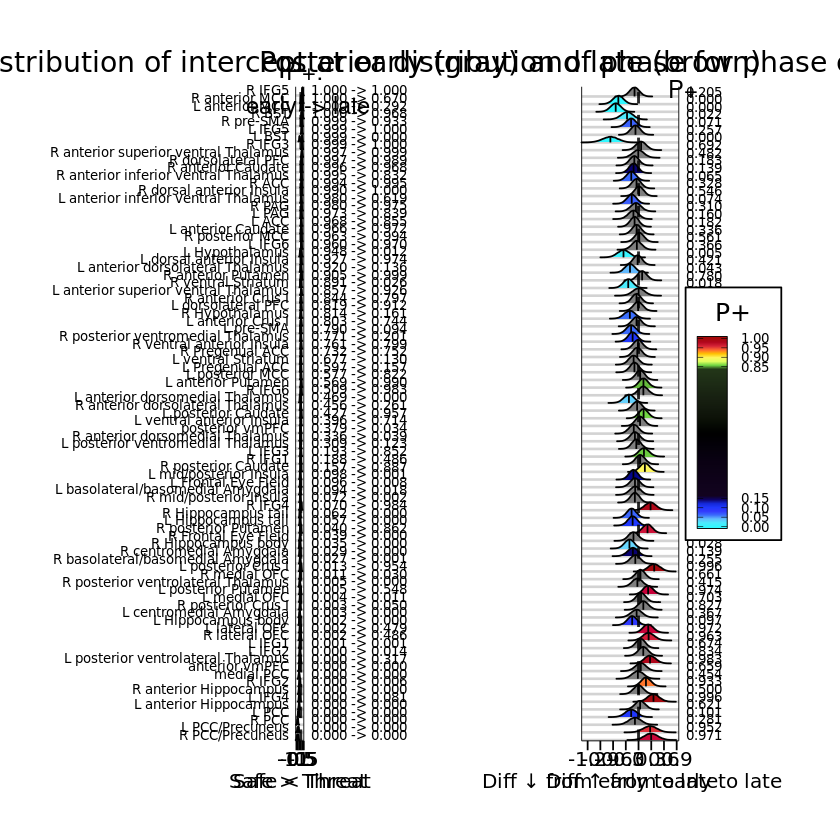

In [9]:
res <- grid.arrange(plotPDP(ps.early, ps.late), plotPDP.period(ps.period), nrow = 1, widths = c(2, 1.2))
ggsave('all_P+.svg', width= 22 , height = 40, plot = res)
ggsave('all_P+.png', width= 22 , height = 40, units = "in", dpi = 300, plot = res)